In [1]:
!pip install nltk
!pip install keras
!pip install tensorflow
!pip install tensorflow_hub
!pip install transformers


[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import log_loss


2023-10-17 17:03:00.786028: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-17 17:03:00.836605: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-17 17:03:00.836670: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-17 17:03:00.836713: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-17 17:03:00.845426: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-17 17:03:00.846561: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

### Load the dataset

In [3]:
 # Load your dataset from the DataFrame
df = pd.read_csv('/workspaces/DSML_Research_Project/Multitarget-CONAN.csv')
df.head()

,INDEX,HATE_SPEECH,COUNTER_NARRATIVE,TARGET,VERSION
0,0,Maybe the UN could talk to those asian and afr...,"You're right, ocean pollution is one of the ma...",other,V1
1,1,‘Juice (Jews) are worse that nukes.’ Caption t...,You'd rather be nuked then?,JEWS,V1
2,2,Foreigners on UK benefits leaps 41% in 5 years...,You seem to be worried about government expend...,MIGRANTS,V1
3,3,"Jews cannot be patriots, since their allegianc...",You can have parents and grandparents born els...,JEWS,V1
4,4,"Israel, Zionism and Jewish Supremacist control...",Wouldn't you say its colonialism from many dif...,JEWS,V1


### Data preprocessing

In [4]:
max_features = 10000
sequence_length = 250

vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

vectorize_layer.adapt(df['HATE_SPEECH'])
label_mapping = {subtype: label for label, subtype in enumerate(df['TARGET'].unique())}
num_classes = len(label_mapping)
len(label_mapping)


8

##### creation of datasets

In [5]:
batch_size = 16
def vectorize_text(text, label):
    return vectorize_layer(text), label

# Map 'hsSubType' to integer labels
df['label'] = df['TARGET'].map(label_mapping)
# Split the data into training (80%) and the remaining (20%)
train_df, remaining_df = train_test_split(df, test_size=0.2, random_state=42)

# Create a TensorFlow dataset for training
raw_train_ds = tf.data.Dataset.from_tensor_slices((train_df['HATE_SPEECH'], train_df['label']))
train_ds = raw_train_ds.map(vectorize_text)
#train_ds = raw_train_ds.map(vectorize_text).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
train_ds = train_ds.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Further split the remaining data into validation (10%) and test (10%)
val_df, test_df = train_test_split(remaining_df, test_size=0.5, random_state=42)

# Create a TensorFlow dataset for validation
raw_val_ds = tf.data.Dataset.from_tensor_slices((val_df['HATE_SPEECH'], val_df['label']))
val_ds = raw_val_ds.map(vectorize_text)
#val_ds = raw_val_ds.map(vectorize_text).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Create a TensorFlow dataset for testing
raw_test_ds = tf.data.Dataset.from_tensor_slices((test_df['HATE_SPEECH'], test_df['label']))
test_ds = raw_test_ds.map(vectorize_text)
test_ds = test_ds.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

for text_batch, label_batch in train_ds.take(1):
    print('text_batch shape:', text_batch.shape)
    print('label_batch shape:', label_batch.shape)
    

text_batch shape: (16, 250)
label_batch shape: (16,)


2023-10-17 17:03:05.220220: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

for text_batch, label_batch in train_ds.take(1):
    print('text_batch shape:', text_batch.shape)
    print('label_batch shape:', label_batch.shape)
    

text_batch shape: (16, 250)
label_batch shape: (16,)


2023-10-17 17:03:05.303719: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-10-17 17:03:05.303787: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### Model definition & Training

In the following code:

I use the CountVectorizer from scikit-learn to convert the text data into a matrix of token counts. 
Each row of the matrix corresponds to a text, and each column corresponds to a feature. 
The matrix represents the word frequencies in each document.

I used fit_transform to fit the vectorizer on the training data and transform it into numerical features. Then, I used transform to transform the test data based on the vocabulary learned from the training data.

The Random Forest classifier was trained on the transformed training data and evaluate its performance on the transformed test data.

This approach allows me to convert the text data into a format that can be used by the Random Forest classifier. 

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

count_vectorizer = CountVectorizer()

# Vectorize the text data
X_train_counts = count_vectorizer.fit_transform(train_df['HATE_SPEECH'])
X_test_counts = count_vectorizer.transform(test_df['HATE_SPEECH'])

# Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_counts, train_df['label'])
nb_score = nb_classifier.score(X_test_counts, test_df['label'])
print(f'Test accuracy: {nb_score}')

Test accuracy: 0.9001996007984032


In [8]:
from sklearn.metrics import classification_report

rf_predictions = nb_classifier.predict(X_test_counts)

# Generate a classification report
classification_rep = classification_report(test_df['label'], rf_predictions, target_names=label_mapping, output_dict=True)
print(classification_report(test_df['label'], rf_predictions, target_names=label_mapping))

# Extract precision, recall, and F1-score
precision = classification_rep['weighted avg']['precision']
recall = classification_rep['weighted avg']['recall']
f1_score = classification_rep['weighted avg']['f1-score']


              precision    recall  f1-score   support

       other       1.00      0.53      0.69        34
        JEWS       1.00      0.94      0.97        65
    MIGRANTS       0.87      0.95      0.91       101
       WOMEN       0.88      0.92      0.90        63
         POC       0.93      0.82      0.87        33
       LGBT+       0.94      0.91      0.93        70
     MUSLIMS       0.84      0.97      0.90       117
    DISABLED       0.93      0.72      0.81        18

    accuracy                           0.90       501
   macro avg       0.92      0.85      0.87       501
weighted avg       0.91      0.90      0.90       501



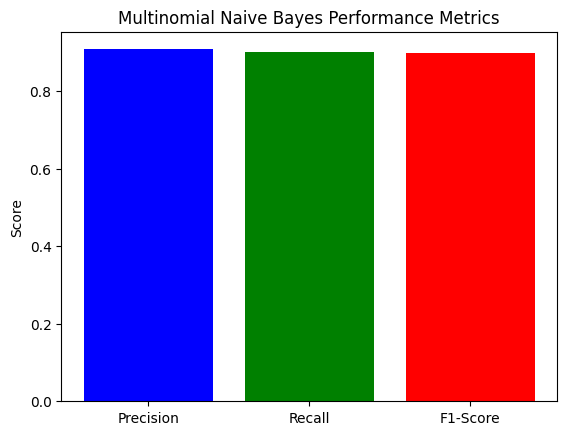

In [10]:
import matplotlib.pyplot as plt

# Data for plotting
metrics = ['Precision', 'Recall', 'F1-Score']
values = [precision, recall, f1_score]

# Create bar plots
plt.bar(metrics, values, color=['blue', 'green', 'red'])
plt.ylabel('Score')
plt.title('Multinomial Naive Bayes Performance Metrics')

# Display the plot
plt.show()


### Save the model (for future use)

In [11]:
import joblib
joblib.dump(nb_classifier, 'Multinomial_naive_Bayes_Classifier.pkl')

['Multinomial_naive_Bayes_Classifier.pkl']

### Test of the model on a custom prompt

In [12]:
import joblib
rf_model = joblib.load('Multinomial_naive_Bayes_Classifier.pkl')

custom_prompts = [
    "I hate muslims",
    "this is a hate speech about jews",
    "Immigrants come to our country and steal our jobs",
    "there are only two sex groups"
]
custom_prompts_counts = count_vectorizer.transform(custom_prompts)

# Make predictions
predictions = rf_model.predict(custom_prompts_counts)
reverse_mapping = {v: k for k, v in label_mapping.items()}
for i, prompt in enumerate(custom_prompts):
    prediction = predictions[i]
    Predicted_Class = reverse_mapping[prediction]
    print(f"the predicted class for '{prompt}' is ", Predicted_Class)

the predicted class for 'I hate muslims' is  MUSLIMS
the predicted class for 'this is a hate speech about jews' is  JEWS
the predicted class for 'Immigrants come to our country and steal our jobs' is  MIGRANTS
the predicted class for 'there are only two sex groups' is  LGBT+


The model is performing well on the data! we have a high fidelity cassification of hatespeech

<img src='https://c.tenor.com/VyApQ-jWyV0AAAAC/happy-borat.gif'>